Note: you may need to restart the kernel to use updated packages.


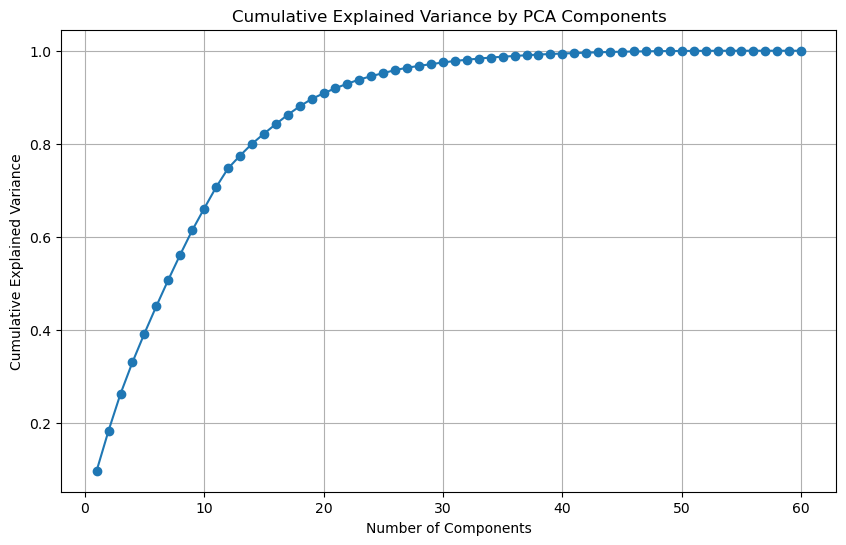

Selected 25 components to retain at least 95% of the variance.
K-means Davies-Bouldin Index: 0.79
Hierarchical Davies-Bouldin Index: 0.86
DBSCAN did not find any clusters (only noise).
GMM Davies-Bouldin Index: 0.89
 [ 100 / 100 ] 100% - 0:00:00 left 
 quantization error: 1.296005783161432
Fuzzy C-Means Davies-Bouldin Index: 1.62


In [ ]:
%pip install scikit-fuzzy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler  # Use MinMaxScaler for normalization
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score
from minisom import MiniSom  # Import SOM
from mpl_toolkits.mplot3d import Axes3D
import skfuzzy as fuzz

# Load the dataset
df = pd.read_csv(os.path.join('..', '..', 'data', 'social-media', 'OnlineNewsPopularity.csv'))

# Preprocessing: Handle missing values
df = df.dropna()

# Sample a subset of the data to reduce memory usage
df = df.sample(frac=0.1, random_state=42)  # Adjust the fraction as needed

# Select relevant numerical columns for clustering
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Step 2: Normalize the features
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(df[numeric_cols])

# Step 3: Dimensionality Reduction (show cumulative variance before selecting components)
pca = PCA()
pca_fit = pca.fit(df_normalized)
explained_variance = np.cumsum(pca_fit.explained_variance_ratio_)

# Plot cumulative variance explained by PCA components
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

# Select enough components to retain at least 95% variance
n_components = np.argmax(explained_variance >= 0.95) + 1  # Add 1 because of 0-based indexing
pca = PCA(n_components=n_components)
pca_fit = pca.fit(df_normalized)
reduced_data = pca.transform(df_normalized)

print(f'Selected {n_components} components to retain at least 95% of the variance.')

# **Algorithm 1: K-means Clustering**
kmeans = KMeans(n_clusters=5, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(reduced_data[:, :3])  # Use the first 3 PCA components for 3D plot

# Evaluate K-means clustering using Davies-Bouldin Index
kmeans_davies_bouldin = davies_bouldin_score(reduced_data[:, :3], df['kmeans_cluster'])
print(f'K-means Davies-Bouldin Index: {kmeans_davies_bouldin:.2f}')

# **Algorithm 2: Hierarchical Clustering**
hierarchical = AgglomerativeClustering(n_clusters=5)
df['hierarchical_cluster'] = hierarchical.fit_predict(reduced_data[:, :3])

# Evaluate Hierarchical clustering using Davies-Bouldin Index
hierarchical_davies_bouldin = davies_bouldin_score(reduced_data[:, :3], df['hierarchical_cluster'])
print(f'Hierarchical Davies-Bouldin Index: {hierarchical_davies_bouldin:.2f}')

# **Algorithm 3: DBSCAN Clustering**
dbscan = DBSCAN(eps=100, min_samples=1)
df['dbscan_cluster'] = dbscan.fit_predict(reduced_data[:, :3])  # Use the first 3 PCA components for 3D plot

# Evaluate DBSCAN clustering using Davies-Bouldin Index (only if clusters are found)
if len(set(df['dbscan_cluster'])) > 1:
    dbscan_davies_bouldin = davies_bouldin_score(reduced_data[:, :3], df['dbscan_cluster'])
    print(f'DBSCAN Davies-Bouldin Index: {dbscan_davies_bouldin:.2f}')
else:
    print('DBSCAN did not find any clusters (only noise).')



# **Algorithm 5: Self-Organizing Map (SOM)**
som = MiniSom(x=10, y=10, input_len=reduced_data.shape[1], sigma=1.0, learning_rate=0.5)
som.train(reduced_data, 100, verbose=True)

# Get the winning neuron for each data point
winning_positions = np.array([som.winner(data) for data in reduced_data])
df['som_cluster'] = [pos[0] * 10 + pos[1] for pos in winning_positions]

# **Algorithm 6: Fuzzy C-Means Clustering**
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(reduced_data.T, c=5, m=2, error=1e-5, maxiter=1000, init=None)

# Assign cluster labels to the DataFrame
df['fuzzy_cmeans_cluster'] = np.argmax(u, axis=0)

# Evaluate Fuzzy C-Means clustering using Davies-Bouldin Index
if len(set(df['fuzzy_cmeans_cluster'])) > 1:
    fuzzy_cmeans_davies_bouldin = davies_bouldin_score(reduced_data[:, :3], df['fuzzy_cmeans_cluster'])
    print(f'Fuzzy C-Means Davies-Bouldin Index: {fuzzy_cmeans_davies_bouldin:.2f}')
else:
    print('Fuzzy C-Means did not find any clusters (only noise).')

# Plot 2D and 3D for each clustering method


GMM Davies-Bouldin Index: 2.37


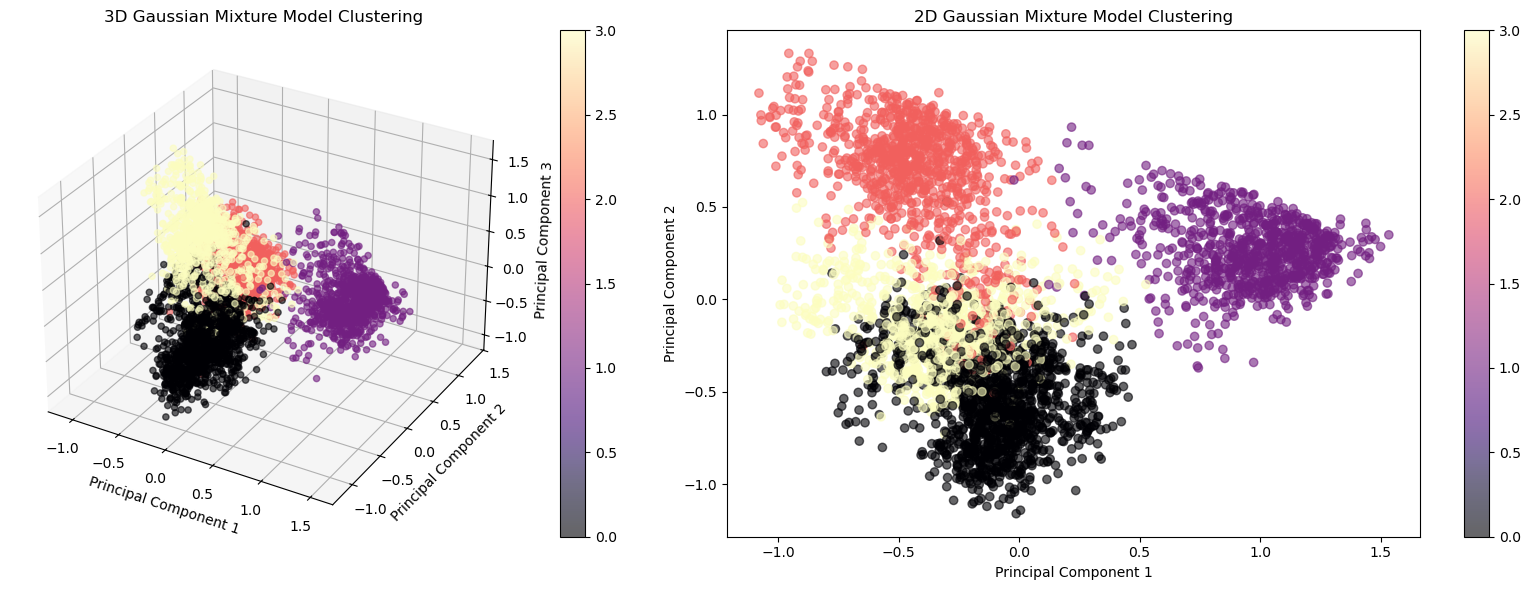

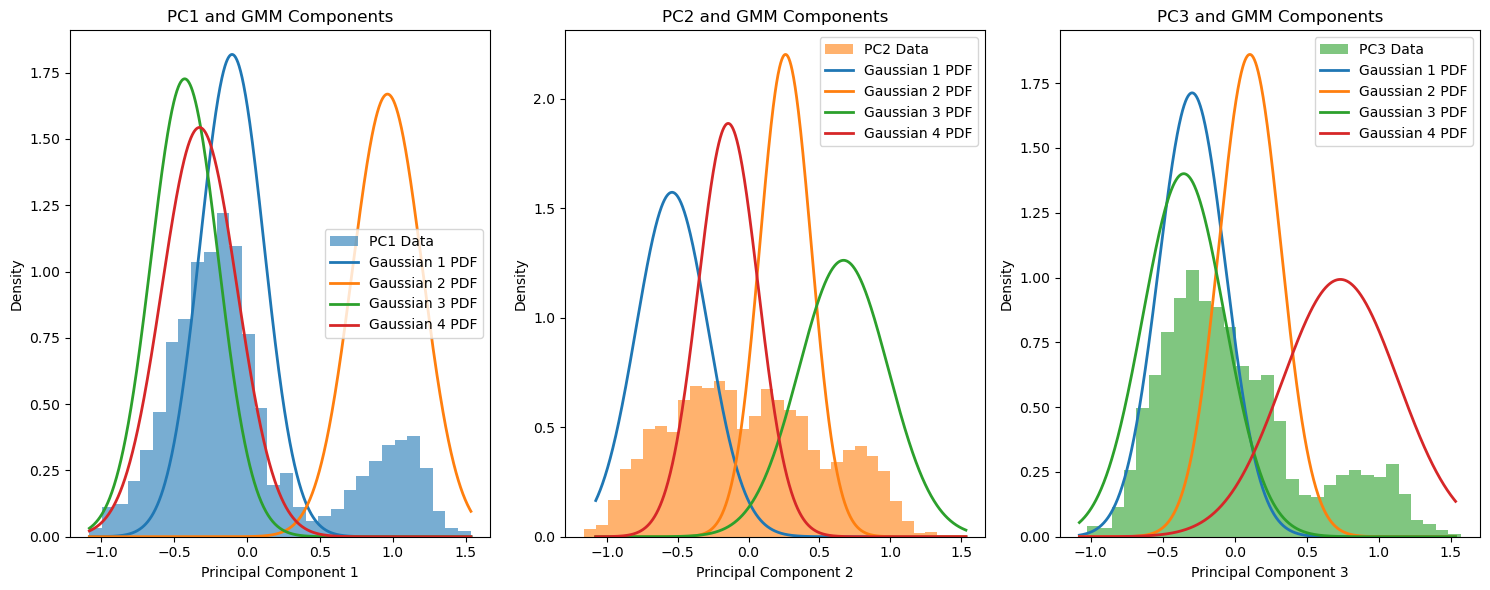

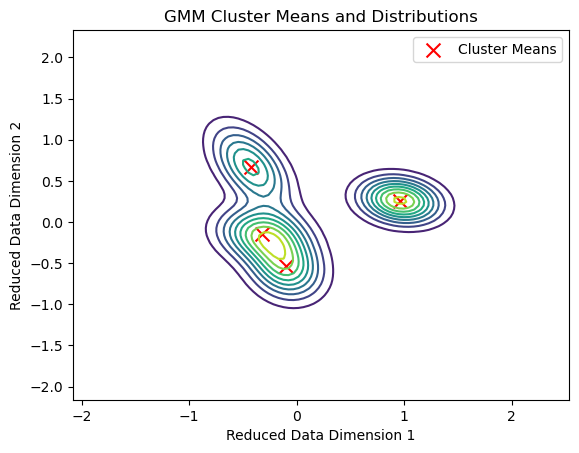

In [72]:
# **Algorithm 4: Gaussian Mixture Model (GMM)**
# Gaussian Mixture Model (GMM) with 6 clusters
gmm = GaussianMixture(n_components=4, random_state=42)
df['gmm_cluster'] = gmm.fit_predict(reduced_data)  # Use the reduced data with all components

# Evaluate GMM clustering using Davies-Bouldin Index
gmm_davies_bouldin = davies_bouldin_score(reduced_data, df['gmm_cluster'])
print(f'GMM Davies-Bouldin Index: {gmm_davies_bouldin:.2f}')

# Plotting both 2D and 3D clustering side by side
fig = plt.figure(figsize=(18, 6))

# 3D GMM plot
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['gmm_cluster'], cmap='magma', alpha=0.6)
ax1.set_title('3D Gaussian Mixture Model Clustering')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')
fig.colorbar(sc1, ax=ax1)

# 2D GMM plot
ax2 = fig.add_subplot(122)
sc2 = ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['gmm_cluster'], cmap='magma', alpha=0.6)
ax2.set_title('2D Gaussian Mixture Model Clustering')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
fig.colorbar(sc2, ax=ax2)

plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

# Assuming 'reduced_data' is your PCA data and 'gmm' is your fitted GMM

# Set up the range of values for plotting
x = np.linspace(reduced_data[:, 0].min(), reduced_data[:, 0].max(), 1000)

# Create a figure for all components
plt.figure(figsize=(15, 6))

# Loop through each of the first three principal components and plot
for i in range(3):
    # Create a subplot for each component
    ax = plt.subplot(1, 3, i + 1)

    # Plot histogram of data along PC1, PC2, or PC3
    ax.hist(reduced_data[:, i], bins=30, density=True, alpha=0.6, label=f'PC{i+1} Data', color=f'C{i}')
    
    # Plot the Gaussian components (PDFs) for the current principal component
    for j in range(gmm.n_components):
        # Each Gaussian component's mean and covariance for the i-th component
        mean = gmm.means_[j, i]  # Mean for the i-th principal component
        covar = gmm.covariances_[j, i, i]  # Covariance for the i-th component
        pdf = norm.pdf(x, mean, np.sqrt(covar))
        ax.plot(x, pdf, label=f'Gaussian {j+1} PDF', lw=2)
    
    # Title and labels
    ax.set_title(f'PC{i+1} and GMM Components')
    ax.set_xlabel(f'Principal Component {i+1}')
    ax.set_ylabel('Density')
    ax.legend()

# Show the plot with all three components
plt.tight_layout()
plt.show()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal

# Assuming gmm is your fitted Gaussian Mixture Model
means = gmm.means_  # Mean of each Gaussian component
covariances = gmm.covariances_  # Covariance of each Gaussian component

# Define a grid of points
x = np.linspace(reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1, 100)
y = np.linspace(reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1, 100)
X, Y = np.meshgrid(x, y)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

# Plot the GMM distribution
plt.contour(X, Y, np.sum([multivariate_normal(mean=means[i][:2], cov=covariances[i][:2, :2]).pdf(pos)
                           for i in range(len(means))], axis=0), levels=10, cmap='viridis')

# Plot the means of the Gaussian components
plt.scatter(means[:, 0], means[:, 1], c='red', marker='x', s=100, label="Cluster Means")
plt.title("GMM Cluster Means and Distributions")
plt.xlabel('Reduced Data Dimension 1')
plt.ylabel('Reduced Data Dimension 2')
plt.legend()
plt.show()




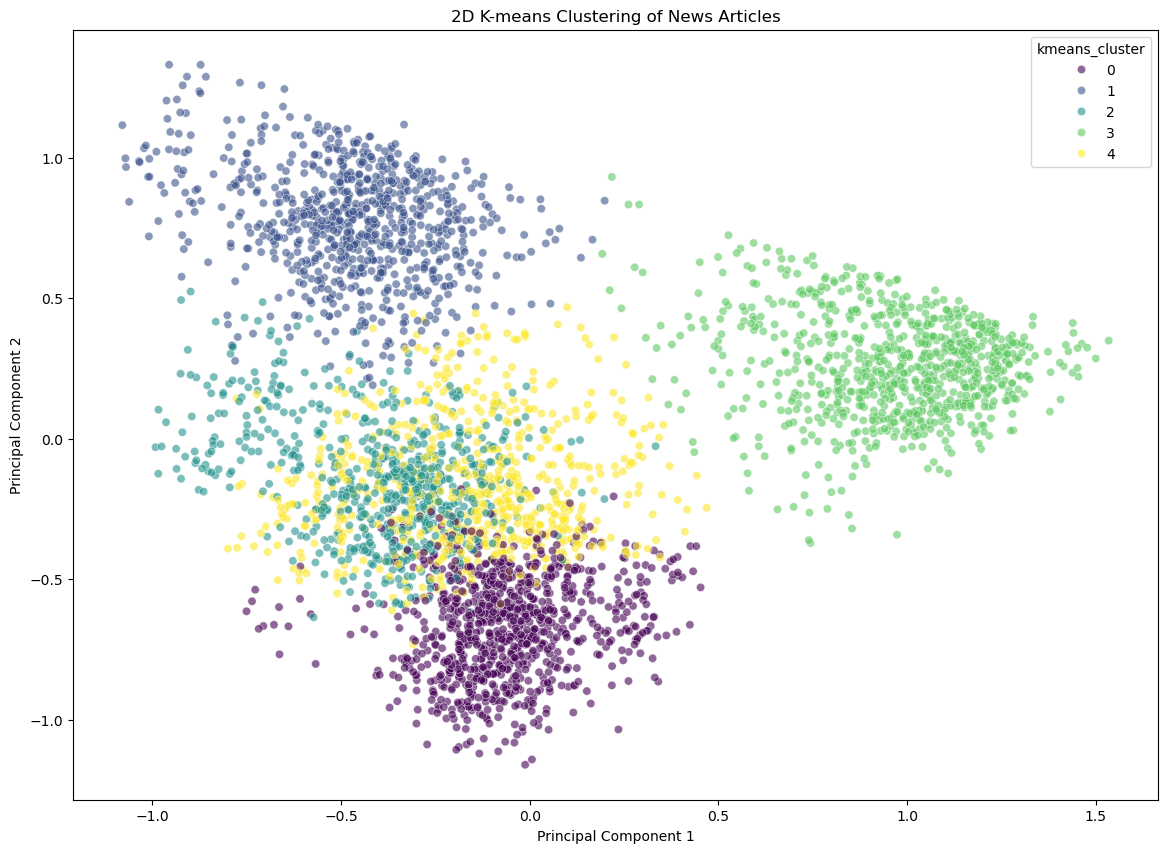

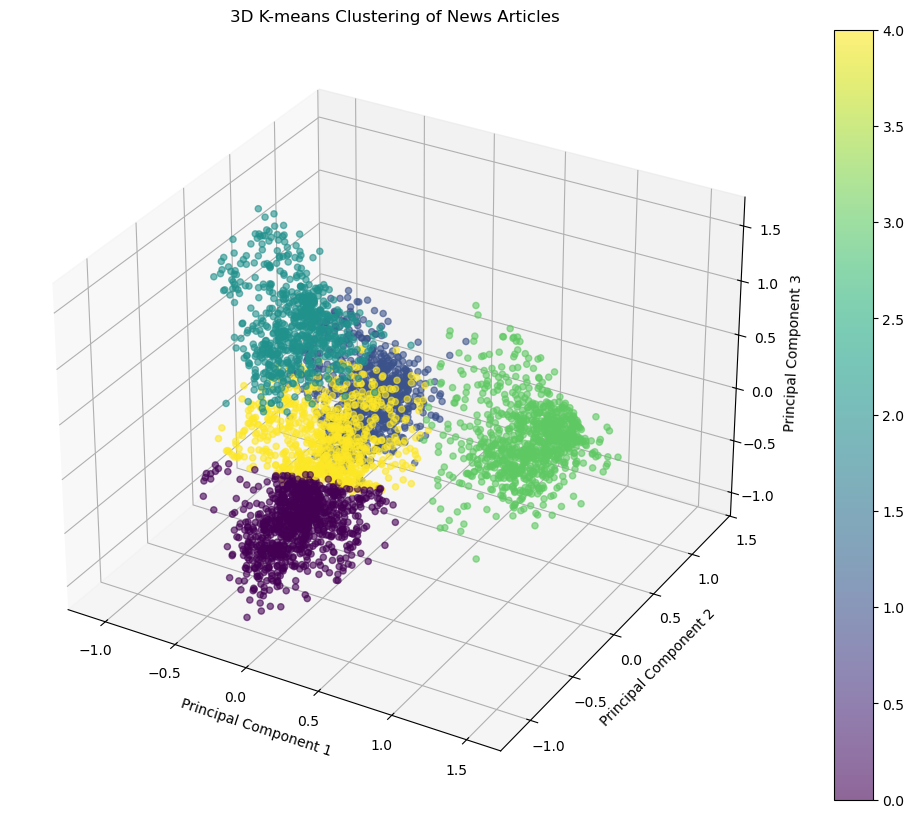

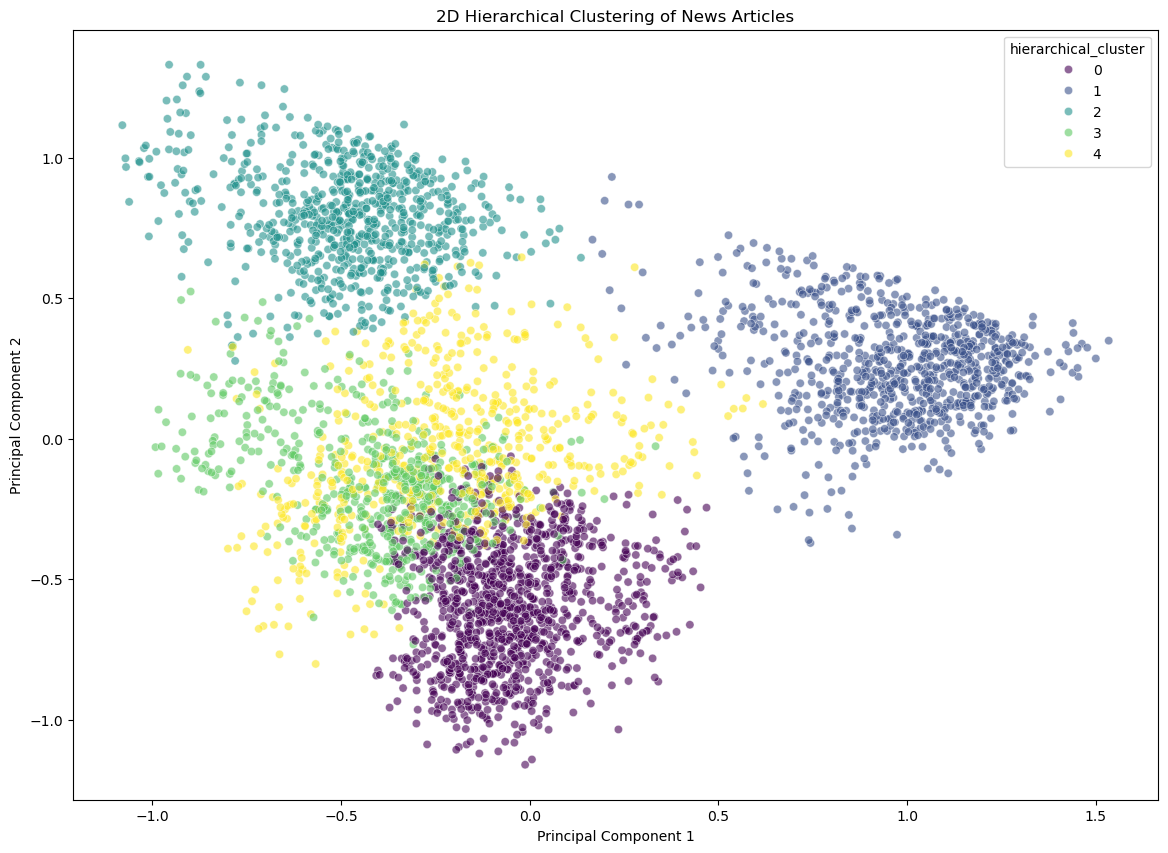

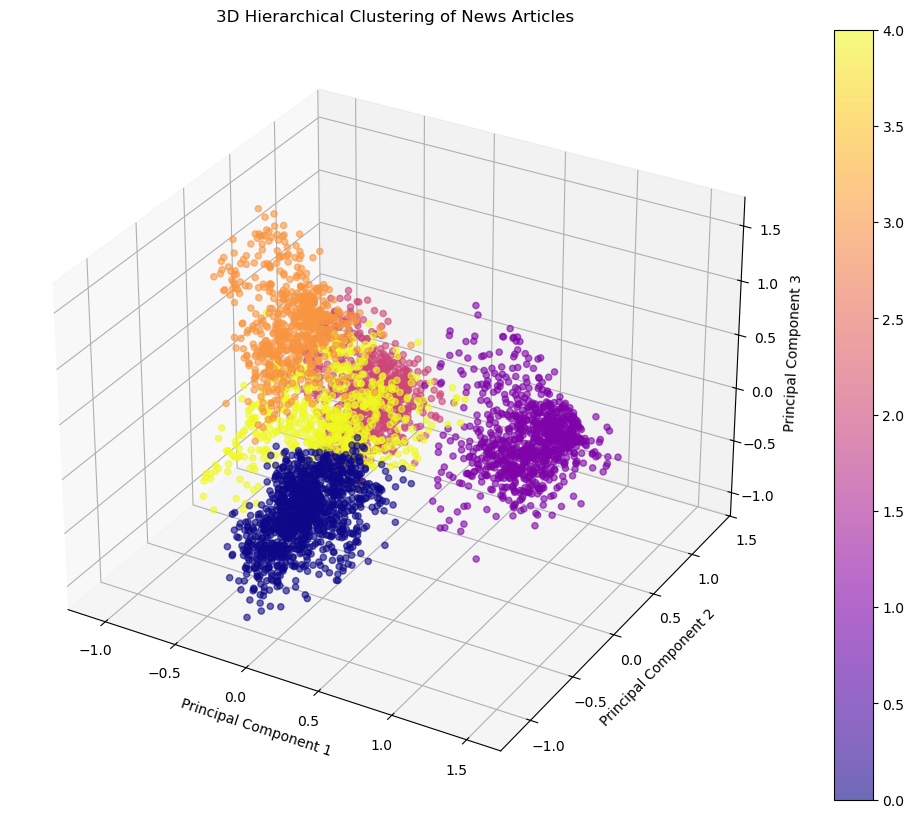

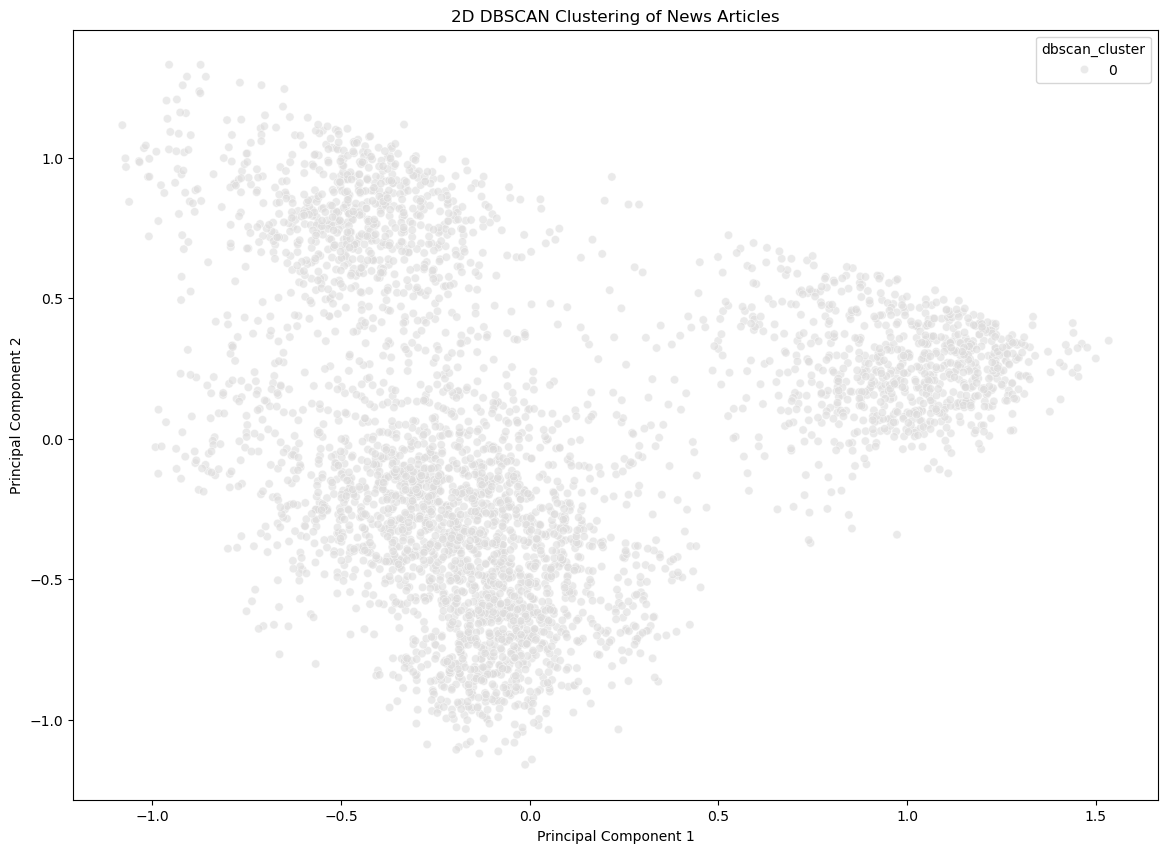

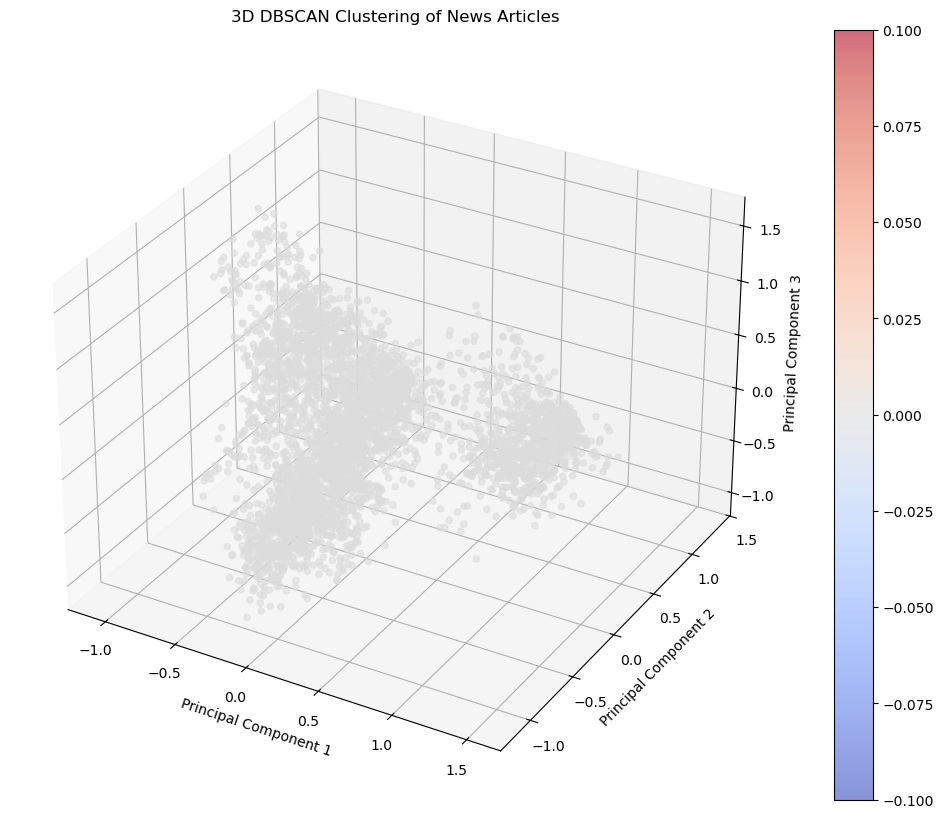

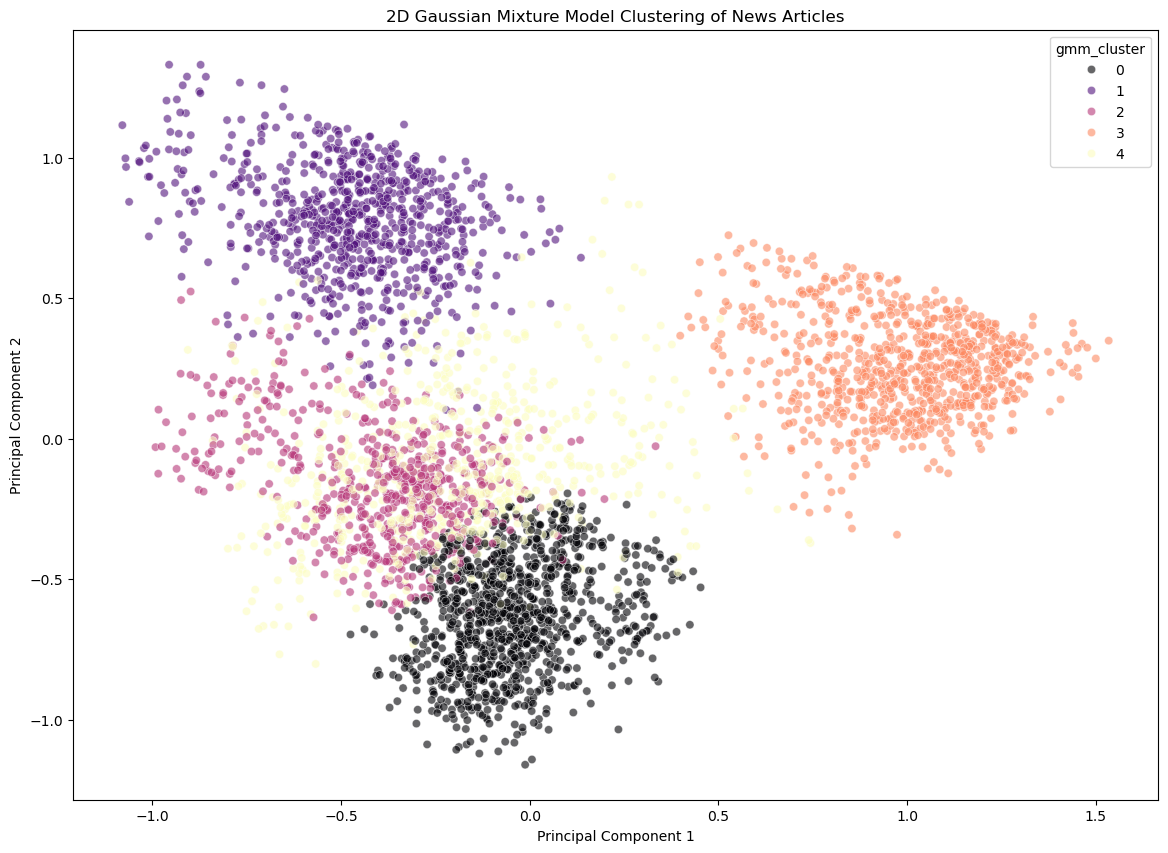

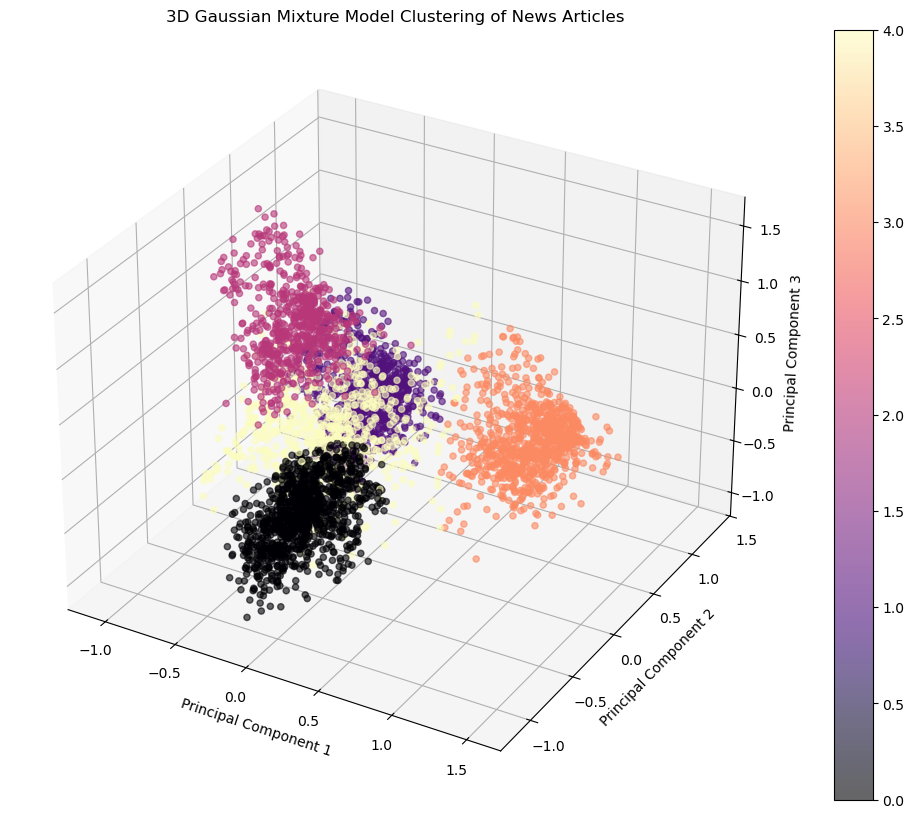

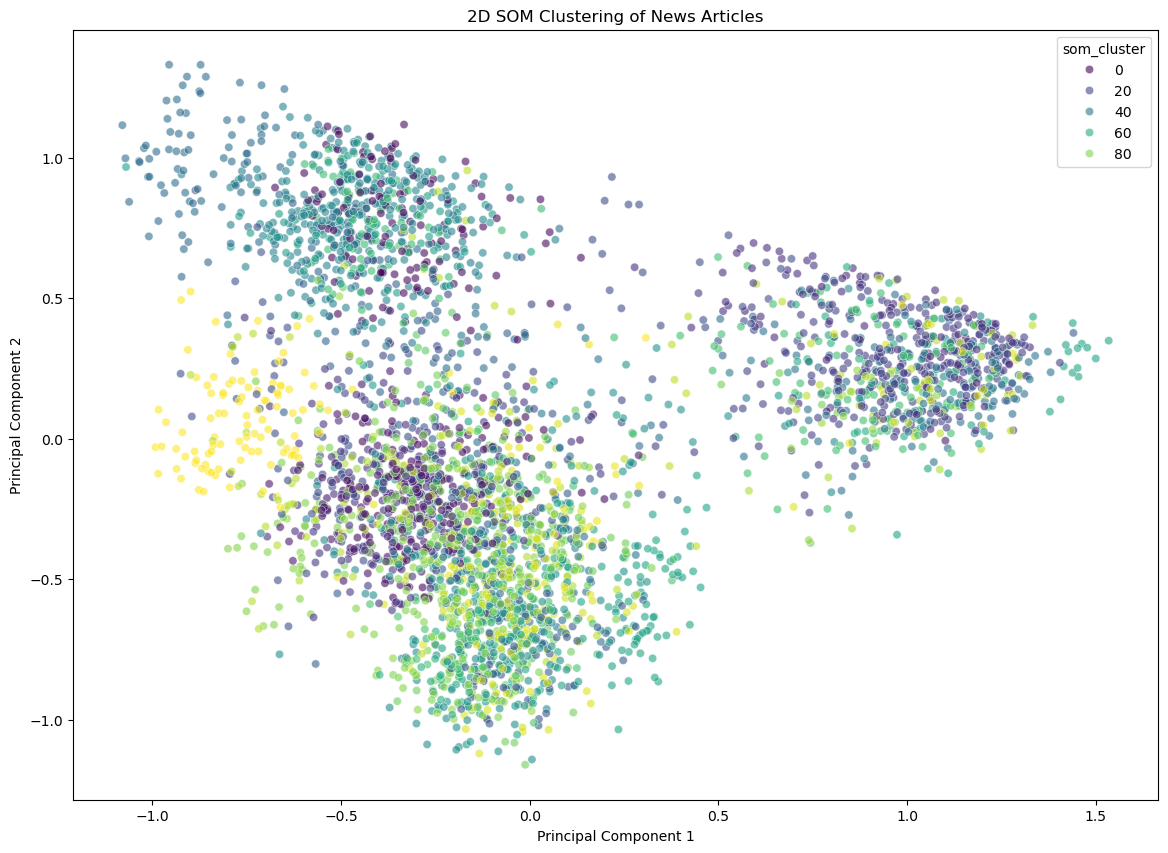

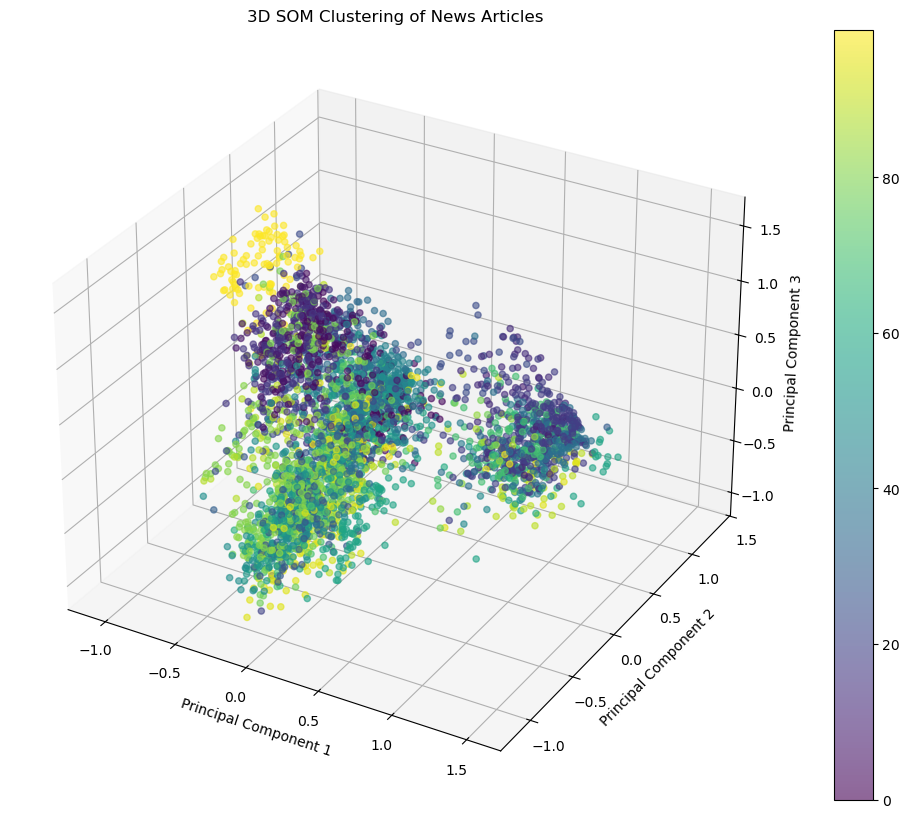

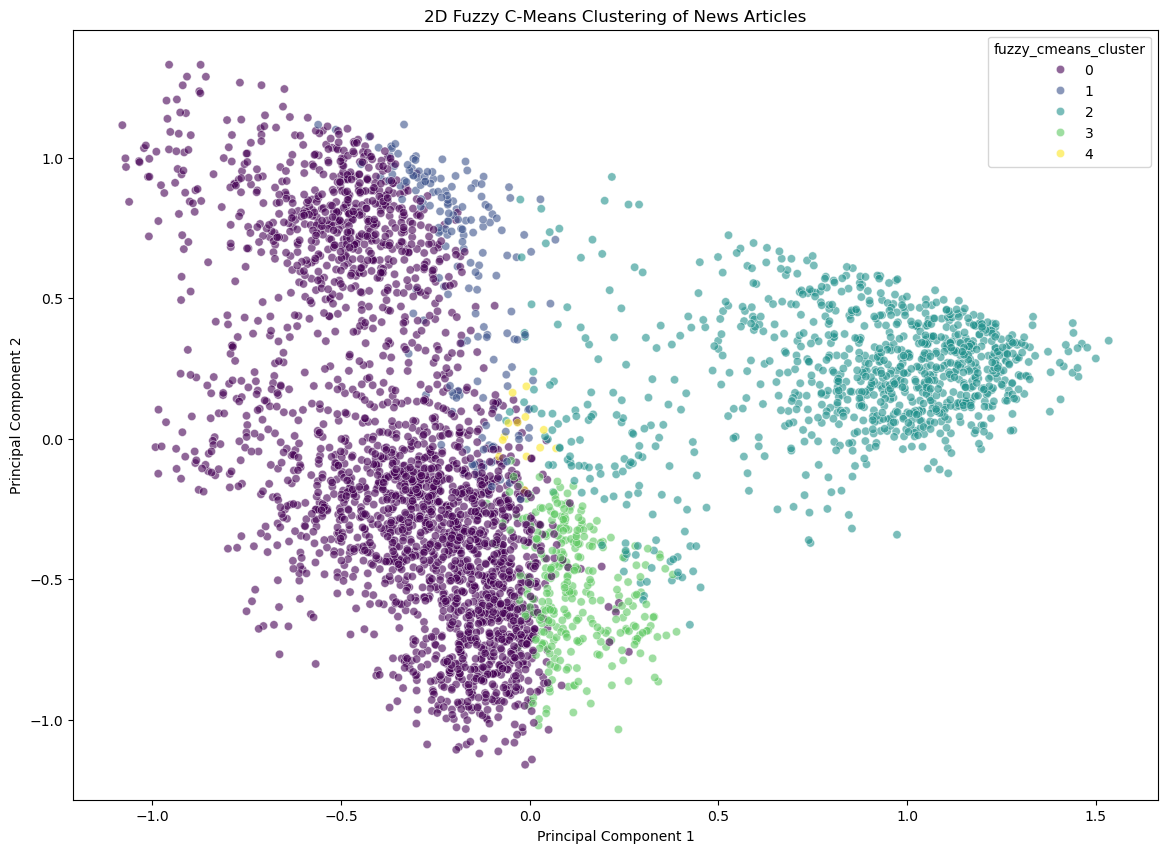

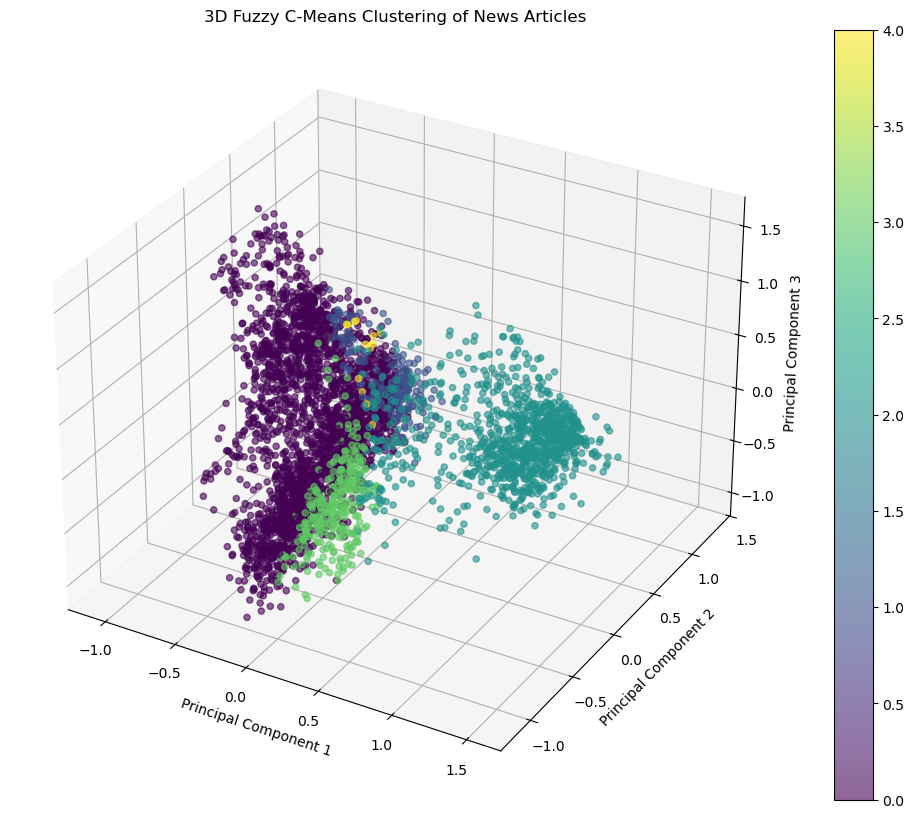

In [ ]:

# 2D K-means plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['kmeans_cluster'], palette='viridis', alpha=0.6)
plt.title('2D K-means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D K-means plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['kmeans_cluster'], cmap='viridis', alpha=0.6)
plt.title('3D K-means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# 2D Hierarchical plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['hierarchical_cluster'], palette='viridis', alpha=0.6)
plt.title('2D Hierarchical Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D Hierarchical plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['hierarchical_cluster'], cmap='plasma', alpha=0.6)
plt.title('3D Hierarchical Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# 2D DBSCAN plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['dbscan_cluster'], palette='coolwarm', alpha=0.6)
plt.title('2D DBSCAN Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D DBSCAN plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['dbscan_cluster'], cmap='coolwarm', alpha=0.6)
plt.title('3D DBSCAN Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# 2D GMM plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['gmm_cluster'], palette='magma', alpha=0.6)
plt.title('2D Gaussian Mixture Model Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



# 2D SOM plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['som_cluster'], palette='viridis', alpha=0.6)
plt.title('2D SOM Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D SOM plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['som_cluster'], cmap='viridis', alpha=0.6)
plt.title('3D SOM Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()

# 2D Fuzzy C-Means plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=df['fuzzy_cmeans_cluster'], palette='viridis', alpha=0.6)
plt.title('2D Fuzzy C-Means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# 3D Fuzzy C-Means plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=df['fuzzy_cmeans_cluster'], cmap='viridis', alpha=0.6)
plt.title('3D Fuzzy C-Means Clustering of News Articles')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.colorbar(sc)
plt.show()
